In [12]:
import warnings
warnings.filterwarnings("ignore")
from run import main
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib.lines import Line2D

In [13]:
# set up dataframe for collecting event data
"""
    start_time: the start time of the simulation (can only be used when you have saved state at that given timestamp)
    finish_time: the total simulation time
    checkpoints: a list of simulation timestamp for state saving e.g. [1000, 5000, 7000]
"""
SIM_TIME = 1000
scheme = 'randomly'
time_network, adversary = main(finish_time=SIM_TIME, scheme=scheme)

Adversary: Start SCAN_HOST at 0.0s.
MTD: IPShuffle triggered 0.0s
MTD: IPShuffle deployed in the network at 0.0s.
Adversary: Processed SCAN_HOST at 10.0s.
Adversary: Start ENUM_HOST at 10.0s.
Adversary: Processed ENUM_HOST at 25.0s.
Adversary: Start SCAN_PORT at 25.0s.
MTD: IPShuffle finished in 40.0s at 40.0s.
MTD: Interrupted SCAN_PORT at 40.0s!
Adversary: Restarting with SCAN_HOST at 42.0s!
Adversary: Start SCAN_HOST at 42.0s.
Adversary: Processed SCAN_HOST at 52.0s.
Adversary: Start ENUM_HOST at 52.0s.
MTD: UserShuffle triggered 60.1s
MTD: UserShuffle deployed in the network at 60.1s.
Adversary: Processed ENUM_HOST at 67.0s.
Adversary: Start SCAN_PORT at 67.0s.
Adversary: Processed SCAN_PORT at 87.0s.
Adversary: Start EXPLOIT_VULN at 87.0s.
MTD: UserShuffle finished in 40.5s at 100.6s.
Adversary: Processed EXPLOIT_VULN at 113.0s.
Adversary: Host 0 has been compromised at 113.0s!
Adversary: Start SCAN_NEIGHBOR at 113.0s.
MTD: PortShuffle triggered 120.3s
MTD: PortShuffle deployed in

In [14]:
mtd_operation_record = pd.DataFrame(time_network.get_mtd_stats().get_record())
attack_operation_record = pd.DataFrame(adversary.get_attack_stats().get_record())
current_directory = os.getcwd()
if not os.path.exists(current_directory+'\\data_analysis'):
    os.makedirs(current_directory+'\\data_analysis')

attack_operation_record.to_csv('data_analysis/attack_operation_record_'+str(SIM_TIME)+'_'+scheme+'.csv',index=False)
mtd_operation_record.to_csv('data_analysis/mtd_operation_record_'+str(SIM_TIME)+'_'+scheme+'.csv', index=False)

In [15]:
# print(time_network.get_mtd_stats().dict())
mtd_operation_record.head()

,name,start_time,finish_time,duration,executed_at
0,IPShuffle,0.000000,40.040017,40.040017,network
1,UserShuffle,60.090392,100.598583,40.508191,reserve
2,PortShuffle,120.316731,160.524904,40.208173,application
3,CompleteTopologyShuffle,180.333050,221.240637,40.907587,network
4,CompleteTopologyShuffle,240.955653,282.089982,41.134329,network


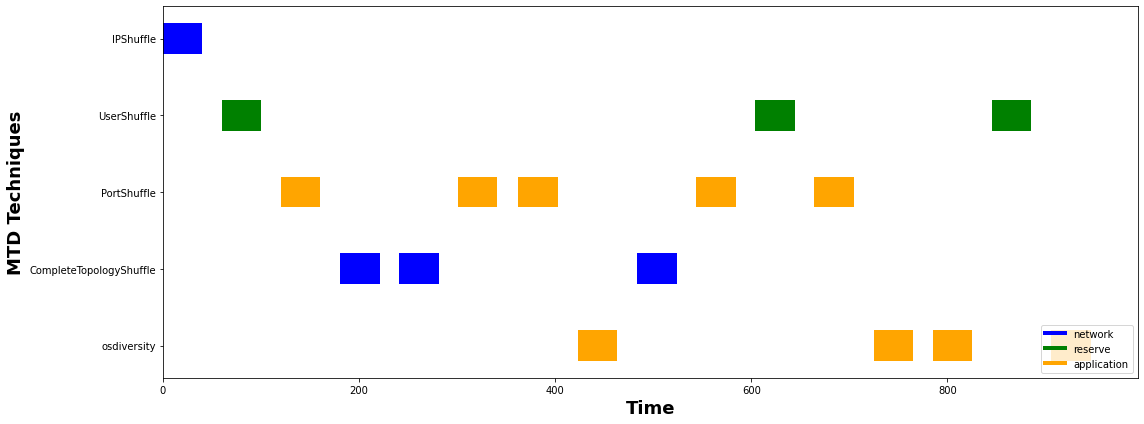

In [16]:
fig, ax = plt.subplots(1, figsize=(16, 6))

colors = ['blue', 'green', 'orange']
mtd_action_legend = []
mtd_action_legend_name = []
for i, v in enumerate(mtd_operation_record['executed_at'].unique()):
    mtd_operation_record.loc[mtd_operation_record['executed_at'] == v, 'color'] = colors[i]
    mtd_action_legend.append(Line2D([0], [0], color=colors[i], lw=4))
    mtd_action_legend_name.append(v)

ax.barh(mtd_operation_record['name'].astype(str), mtd_operation_record['duration'], left=mtd_operation_record['start_time'], height=0.4, color=mtd_operation_record['color'] )
ax.legend(mtd_action_legend, mtd_action_legend_name, loc='lower right')
plt.gca().invert_yaxis()


custom_lines_mtd = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4)]


plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('MTD Techniques', weight='bold', fontsize=18)
fig.tight_layout()
plt.savefig('data_analysis/mtd_record.png')
plt.show()

In [17]:
attack_operation_record.head()

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
0,SCAN_HOST,0.000000,10.000000,10.000000,-1,0,0,0,None,[],None,None
1,ENUM_HOST,10.000000,25.000000,15.000000,-1,0,0,0,None,[],None,None
2,SCAN_PORT,25.000000,40.040017,15.040017,0,1,0,0,None,[],network,IPShuffle
3,SCAN_HOST,42.040017,52.040017,10.000000,-1,0,0,0,None,[],None,None
4,ENUM_HOST,52.040017,67.040017,15.000000,-1,0,0,0,None,[],None,None


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


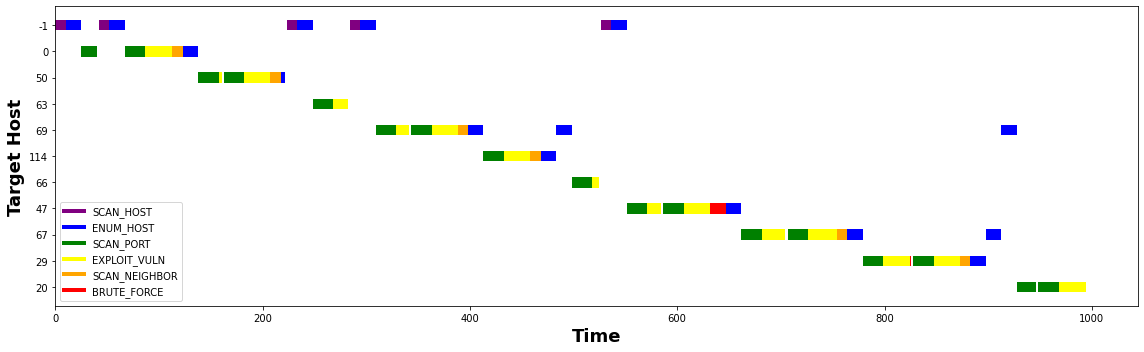

In [18]:
fig2, ax2 = plt.subplots(1, figsize=(16, 5))

colors = ['purple', 'blue', 'green', 'yellow', 'orange', 'red']
attack_action_legend = []
attack_action_legend_name = []
for i, v in enumerate(attack_operation_record['name'].unique()):
    attack_operation_record.loc[attack_operation_record.name == v, 'color'] = colors[i]
    attack_action_legend.append(Line2D([0], [0], color=colors[i], lw=4))
    attack_action_legend_name.append(v)

ax2.barh(attack_operation_record['current_host'].astype(str), attack_operation_record['duration'], left=attack_operation_record['start_time'], height=0.4, color=attack_operation_record['color'] )

ax2.legend(attack_action_legend, attack_action_legend_name, loc='lower left')
plt.gca().invert_yaxis()
plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('Target Host', weight='bold', fontsize=18)
fig2.tight_layout()
plt.savefig('data_analysis/attack_action_record.png')
plt.show()

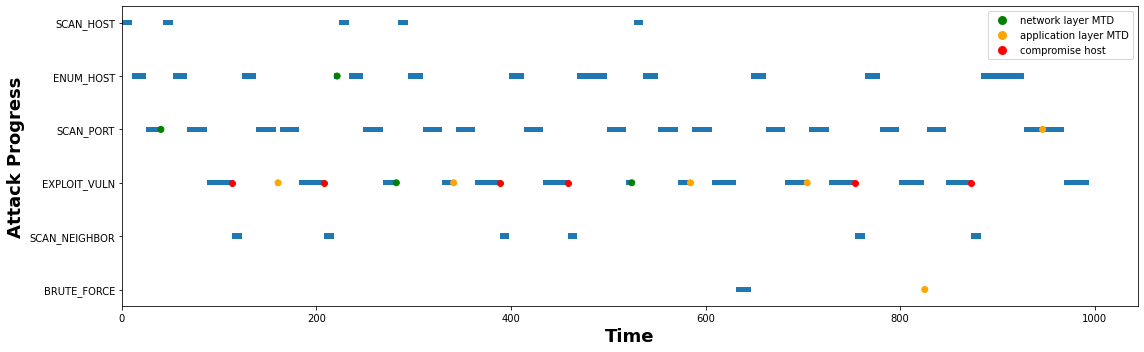

In [19]:
fig4, ax4 = plt.subplots(1, figsize=(16, 5))
ax4.barh(attack_operation_record['name'], attack_operation_record['duration'], left=attack_operation_record['start_time'], height=0.1, zorder=1)


interrupted_record = attack_operation_record[attack_operation_record['interrupted_in']!='None']
interrupted_record['color'] = np.where(interrupted_record['interrupted_in']=='network', 'green', 'orange')
ax4.scatter(interrupted_record['finish_time'], interrupted_record['name'], color=interrupted_record['color'], zorder=3)


compromise_record = attack_operation_record[attack_operation_record['compromise_host'] != 'None']
ax4.scatter(compromise_record['finish_time'], compromise_record['name'], color='red', zorder=2)


custom_lines_attack = [Line2D([0], [0], marker='o',color='w', markerfacecolor='green', markersize=10),
                       Line2D([0], [0], marker='o',color='w', markerfacecolor='orange', markersize=10),
                       Line2D([0], [0], marker='o',color='w', markerfacecolor='red', markersize=10),]

ax4.legend(custom_lines_attack, ['network layer MTD', 'application layer MTD', 'compromise host'], loc='upper right')

plt.gca().invert_yaxis()
plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('Attack Progress', weight='bold', fontsize=18)
fig4.tight_layout()
plt.savefig('data_analysis/attack_record.png')
plt.show()

In [20]:
attack_operation_record[(attack_operation_record['name'] == 'SCAN_PORT') & (attack_operation_record['compromise_host'] != 'None')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by,color


In [21]:
attack_operation_record[(attack_operation_record['name'] == 'EXPLOIT_VULN') & (attack_operation_record['compromise_host'] != 'None')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by,color
6,EXPLOIT_VULN,87.040017,113.008983,25.968965,0,2,0,0,0,"[Margareta, Guenevere, Codee, Bobinette, Jessika]",None,None,yellow
12,EXPLOIT_VULN,182.524904,207.560045,25.035141,50,1,15,1,50,"[Drusy, Maxi, Chrissy, Sharai]",None,None,yellow
24,EXPLOIT_VULN,363.025400,388.154723,25.129323,69,1,30,2,69,"[Petronilla, Dawna, Alecia, Pansy, Ardeen]",None,None,yellow
28,EXPLOIT_VULN,433.154723,458.189388,25.034665,114,1,72,3,114,"[Franni, Alyda, Britteny, Cele, Dina]",None,None,yellow
45,EXPLOIT_VULN,726.465176,753.913293,27.448117,67,1,148,4,67,"[Felicdad, Denyse, Marijo, Con]",None,None,yellow
52,EXPLOIT_VULN,847.344910,872.732356,25.387446,29,1,168,5,29,"[Carlee, Fleur, Daisi, Arlana]",None,None,yellow


In [22]:
attack_operation_record[(attack_operation_record['name'] == 'BRUTE_FORCE') & (attack_operation_record['compromise_host'] != 'None')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by,color
